# Build an agent from scratch

**Simple ReAct Agent from Scratch:** based on https://til.simonwillison.net/llms/python-react-pattern

import libraries

In [1]:
import openai
import re
import httpx
import os
from dotenv import load_dotenv

_ = load_dotenv()
from openai import OpenAI

ModuleNotFoundError: No module named 'openai'

### language model

In [ ]:
Initialise the language model - we will use OpenAI

In [ ]:
client = OpenAI()

lets test it, passing in "hello, world"...

In [ ]:
chat_completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Hello world"}]
)

lets see the response from the LLM

In [ ]:
chat_completion.choices[0].message.content

### create the agent
Agent Class: A conversational AI wrapper that maintains conversation history and calls GPT-4o via OpenAI API.

Attributes:

 - system - Optional system prompt that sets the AI's behavior/role for the entire conversation
 - messages - List storing the complete conversation history (system, user, and assistant messages)

Methods:
 - \_\_call__() - Adds user message, gets AI response, stores both in history, returns response
 - execute() - Makes the actual API call to GPT-4o and extracts the response content

In [ ]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role": "system", "content": system})

    def __call__(self, message):
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})
        return result

    def execute(self):
        completion = client.chat.completions.create(
                        model="gpt-4o", 
                        temperature=0,
                        messages=self.messages)
        return completion.choices[0].message.content

**ReAct Pattern Prompt:** 

Implements Reasoning and Acting - a structured loop where the AI systematically solves problems by thinking (Thought), using available tools (Action), pausing for external processing (PAUSE), receiving results (Observation), then providing a final answer. This prevents hallucination by forcing the AI to use actual tools rather than guessing.

**Key components:**

 - Loop structure: Thought → Action → PAUSE → Observation → Answer
 - Available tools: Calculator and dog breed weight lookup
 - Control mechanism: PAUSE signals when external intervention is needed
 - Format example: Shows exact interaction pattern expected

In [ ]:
prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

**Toy Functions:** 

Simple example functions that demonstrate the pattern. In real applications, these would be domain-specific tools tailored to your actual problem space.

**Key points:**
 - calculate() - Uses eval() to perform mathematical operations (unsafe for production)
 - average_dog_weight() - Returns hardcoded weights for a few breeds, defaults to 50 lbs
 - known_actions - Dictionary mapping action names to their corresponding functions for easy lookup

This setup shows how to create a function registry that the agent can call dynamically based on the action names in the prompt.

In [ ]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

initialise the agent...

In [ ]:
abot = Agent(prompt)

call it once, with a promt...

In [ ]:
result = abot("How much does a toy poodle weigh?")
print(result)

call the toy function directly...

In [ ]:
result = average_dog_weight("Toy Poodle")

In [ ]:
result

format the result as an observation for the next prompt

In [ ]:
next_prompt = "Observation: {}".format(result)

show us the answer

In [ ]:
abot(next_prompt)

if we want to see more details we can inspect the messages attribute on the agent...

In [ ]:
abot.messages

### lets try again
starting by re-initialising the agent (clearing all the prompts/responses/messages) 

In [ ]:
abot = Agent(prompt)

In [ ]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
abot(question)

In [ ]:
next_prompt = "Observation: {}".format(average_dog_weight("Border Collie"))
print(next_prompt)

In [ ]:
abot(next_prompt)

In [ ]:
next_prompt = "Observation: {}".format(average_dog_weight("Scottish Terrier"))
print(next_prompt)

In [ ]:
abot(next_prompt)

In [ ]:
next_prompt = "Observation: {}".format(eval("37 + 20"))
print(next_prompt)

In [ ]:
abot(next_prompt)

### add loop

In [ ]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

In [ ]:
def query(question, max_turns=5):
    i = 0
    bot = Agent(prompt)
    next_prompt = question
    while i < max_turns:
        i += 1
        result = bot(next_prompt)
        print(result)
        actions = [
            action_re.match(a) 
            for a in result.split('\n') 
            if action_re.match(a)
        ]
        if actions:
            # There is an action to run
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            print(" -- running {} {}".format(action, action_input))
            observation = known_actions[action](action_input)
            print("Observation:", observation)
            next_prompt = "Observation: {}".format(observation)
        else:
            return

In [ ]:
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)

### Here is a diagram of this workflow

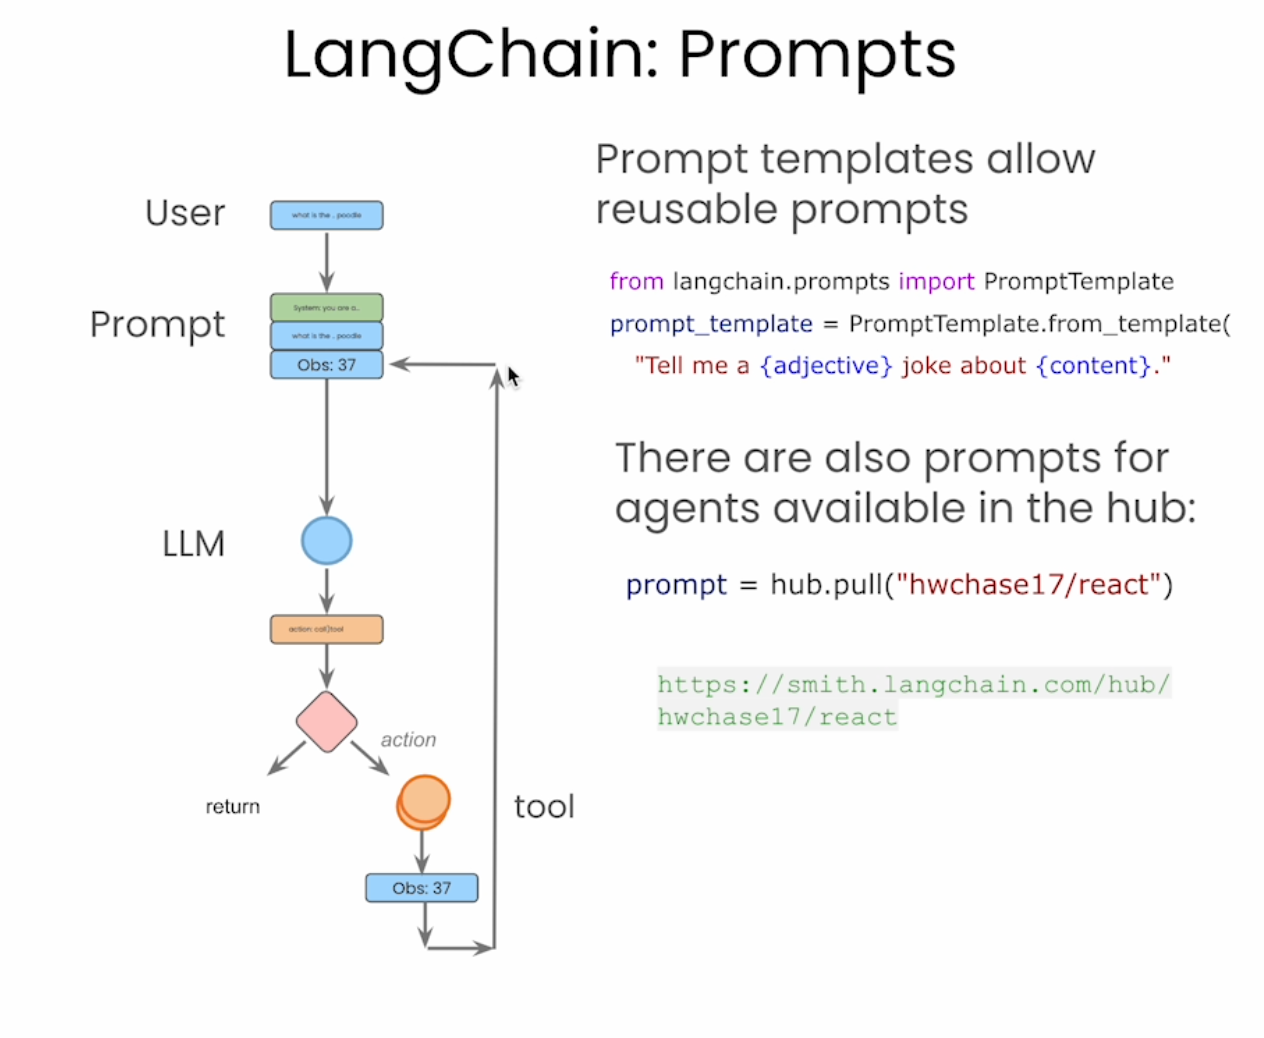